# About Dataset

link https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices


This document explores a dataset containing prices and attributes for approximately 54,000 round-cut diamonds.
There are 53,940 diamonds in the dataset with 10 features (carat, cut, color, clarity, depth, table, price, x, y, and z). Most variables are numeric in nature, but the variables cut, color, and clarity are ordered factor variables with the following levels.
About the currency for the price column: it is Price ($)


## 0. Runtime & Libraries

In [1]:

# We keep installs minimal — Colab already has these.
# If you run locally and miss a package, uncomment the relevant pip lines.
# !pip install -q pandas scikit-learn matplotlib tensorflow

import sys, platform, math, json, os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# TensorFlow for the neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Python:", sys.version)
print("TF:", tf.__version__)
print("SKLearn OK")


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TF: 2.19.0
SKLearn OK


## 1. Load the dataset

In [2]:

# We support two flows:
# A) If a local file path exists (e.g., when this notebook is executed with the file alongside), we load it.
# B) Otherwise (e.g., fresh Colab), we ask you to upload the CSV interactively.

import os
import pandas as pd

CSV_PATHS = [
    "/mnt/data/diamonds.csv",      # path baked into this exported notebook (works here)
    "diamonds.csv",               # same-folder fallback
    "/content/diamonds.csv"       # common path on Colab if you place it under /content
]

df = None
for p in CSV_PATHS:
    if os.path.exists(p):
        print(f"Loading diamonds from: {p}")
        df = pd.read_csv(p)
        break

if df is None:
    try:
        from google.colab import files
        print("Upload diamonds.csv (from your computer) when prompted...")
        uploaded = files.upload()   # opens an upload dialog in Colab
        fname = list(uploaded.keys())[0]
        df = pd.read_csv(fname)
        print("Loaded:", fname)
    except Exception as e:
        raise SystemExit("❌ Could not find or upload diamonds.csv — place it next to this notebook or upload it in Colab.") from e

print("Rows, Cols:", df.shape)
df.head()


Upload diamonds.csv (from your computer) when prompted...


Saving diamonds.csv to diamonds.csv
Loaded: diamonds.csv
Rows, Cols: (53940, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 2. Data understanding — columns & target

In [3]:

# Typical diamonds dataset columns:
# - carat: weight of the diamond (numeric)
# - cut, color, clarity: categorical quality grades
# - depth, table: proportions (numeric)
# - x, y, z: dimensions in mm (numeric)
# - price: target (numeric, USD)
#
# We'll confirm:
print("\nColumns:", list(df.columns))
print("\nInfo:")
print(df.info())
print("\nBasic stats:")
display(df.describe(include="all").transpose())



Columns: ['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB
None

Basic stats:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,53940.0,NaN,NaN,NaN,26970.5,15571.281097,1.0,13485.75,26970.5,40455.25,53940.0
carat,53940.0,NaN,NaN,NaN,0.79794,0.474011,0.2,0.4,0.7,1.04,5.01
cut,53940,5,Ideal,21551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,53940,7,G,11292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clarity,53940,8,SI1,13065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depth,53940.0,NaN,NaN,NaN,61.749405,1.432621,43.0,61.0,61.8,62.5,79.0
table,53940.0,NaN,NaN,NaN,57.457184,2.234491,43.0,56.0,57.0,59.0,95.0
price,53940.0,NaN,NaN,NaN,3932.799722,3989.439738,326.0,950.0,2401.0,5324.25,18823.0
x,53940.0,NaN,NaN,NaN,5.731157,1.121761,0.0,4.71,5.7,6.54,10.74
y,53940.0,NaN,NaN,NaN,5.734526,1.142135,0.0,4.72,5.71,6.54,58.9


## 3. Quick data quality checks

In [4]:

# Missing values? Duplicates? Any zeros in dimensions?
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing)

dups = df.duplicated().sum()
print("\nDuplicate rows:", dups)

# Check non-positive dimensions (occasionally some datasets have 0 x/y/z)
dim_issues = (df[['x','y','z']] <= 0).any(axis=1).sum() if set(['x','y','z']).issubset(df.columns) else 0
print("Rows with non-positive x/y/z:", dim_issues)


Missing values per column:
 Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

Duplicate rows: 0
Rows with non-positive x/y/z: 20


## 4. Target distribution (price)

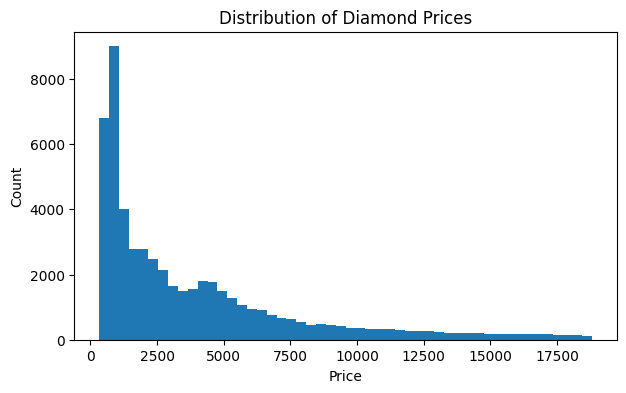

In [5]:

# Why: Visualize target to understand scale and skew. This informs metrics (MAE, RMSE) and training stability.
plt.figure(figsize=(7,4))
plt.hist(df['price'], bins=50)
plt.title("Distribution of Diamond Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


## 5. Train/Validation/Test split

In [6]:

# Why split? To estimate generalization. We'll hold out a test set we never touch during training,
# and also create a validation set to tune models/hyperparameters fairly.

TARGET = "price"
y = df[TARGET].values

# Choose features: numeric + categoricals
categorical = [c for c in ['cut', 'color', 'clarity'] if c in df.columns]
numeric = [c for c in ['carat','depth','table','x','y','z'] if c in df.columns]

X = df[categorical + numeric].copy()

# First split off a test set (20%), then split remaining into train/val (80% -> 64/16)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)  # 0.8*0.2=0.16

print("Shapes -> Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)
print("Categorical:", categorical)
print("Numeric:", numeric)


Shapes -> Train: (34521, 9)  Val: (8631, 9)  Test: (10788, 9)
Categorical: ['cut', 'color', 'clarity']
Numeric: ['carat', 'depth', 'table', 'x', 'y', 'z']


## 6. Preprocessing for classical ML (One‑Hot for categoricals)

In [7]:

# Why OneHot? Tree models can handle categoricals via one-hot without scaling numerical features.
# We build a ColumnTransformer that applies OneHot to categoricals and passes numeric as-is.

pre_ml = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric),
    ]
)


## 7. Baseline model: Linear Regression

In [15]:
# Why baseline first? It sets a floor for performance and catches leaks/issues.
linreg = Pipeline(steps=[
    ("prep", pre_ml),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)

def eval_reg(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    # Calculate RMSE by taking the square root of the mean squared error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"model": label, "MAE": mae, "RMSE": rmse, "R2": r2}

lin_val = eval_reg(y_val, linreg.predict(X_val), "LinearRegression (val)")
lin_test = eval_reg(y_test, linreg.predict(X_test), "LinearRegression (test)")

print(lin_val)
print(lin_test)

{'model': 'LinearRegression (val)', 'MAE': 738.9951977454009, 'RMSE': np.float64(1100.9445742411565), 'R2': 0.9230791796172934}
{'model': 'LinearRegression (test)', 'MAE': 739.7010572221229, 'RMSE': np.float64(1135.3706693178456), 'R2': 0.9189104211367292}


## 8. Tabular workhorse: RandomForestRegressor

In [16]:

# Why RF? Nonlinear, robust to outliers, handles mixed features well, strong baseline for tabular data.
rf = Pipeline(steps=[
    ("prep", pre_ml),
    ("model", RandomForestRegressor(
        n_estimators=300,      # more trees -> better but slower
        max_depth=None,        # let trees grow; we'll trust OOB/val to catch overfit
        n_jobs=-1,
        random_state=42
    ))
])

rf.fit(X_train, y_train)

rf_val = eval_reg(y_val, rf.predict(X_val), "RandomForest (val)")
rf_test = eval_reg(y_test, rf.predict(X_test), "RandomForest (test)")

print(rf_val)
print(rf_test)


{'model': 'RandomForest (val)', 'MAE': 272.03320053774416, 'RMSE': np.float64(557.6533742955485), 'R2': 0.980264793939838}
{'model': 'RandomForest (test)', 'MAE': 275.7825978302612, 'RMSE': np.float64(556.3724709032917), 'R2': 0.9805275332978904}


## 9. Preprocessing for Neural Network (One‑Hot + StandardScaler)

In [17]:

# Neural networks are sensitive to feature scale. We'll:
# - OneHot encode categoricals
# - Standardize numeric features to mean=0, std=1
# Then we will feed the dense numerical feature matrix to Keras.

pre_nn = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical),
        ("num", StandardScaler(), numeric),
    ]
)

# Fit the transformer on train only, then transform splits to dense numpy arrays.
X_train_nn = pre_nn.fit_transform(X_train)
X_val_nn   = pre_nn.transform(X_val)
X_test_nn  = pre_nn.transform(X_test)

input_dim = X_train_nn.shape[1]
input_dim


26

## 10. Build & train the Neural Network

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,129 (188.00 KB)

 Trainable params: 48,129 (188.00 KB)

 Non-trainable params: 0 (0.00 B)

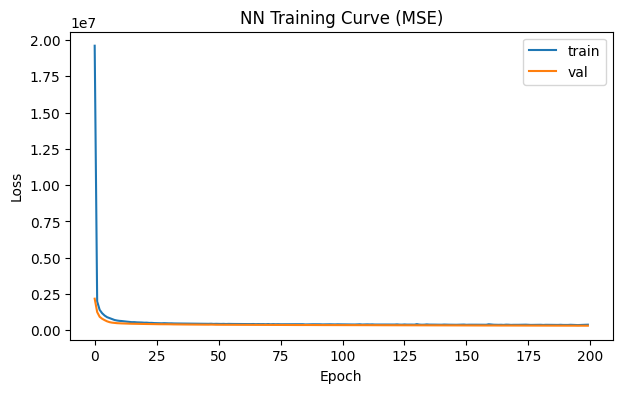

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'model': 'NeuralNet (val)', 'MAE': 288.29608154296875, 'RMSE': np.float64(565.2658666503754), 'R2': 0.9797223210334778}
{'model': 'NeuralNet (test)', 'MAE': 293.5867004394531, 'RMSE': np.float64(560.5414235362093), 'R2': 0.9802346229553223}


In [18]:

# We'll use a small MLP with dropout. We monitor validation loss and early-stop to avoid overfitting.
tf.random.set_seed(42)

def build_mlp(dim):
    model = keras.Sequential([
        layers.Input(shape=(dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.15),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.10),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)  # regression output
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae"),
                 keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

mlp = build_mlp(input_dim)
mlp.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = mlp.fit(
    X_train_nn, y_train,
    validation_data=(X_val_nn, y_val),
    epochs=200,
    batch_size=256,
    verbose=0,
    callbacks=callbacks
)

# Plot training curves (loss)
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("NN Training Curve (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate
y_val_pred_nn = mlp.predict(X_val_nn).ravel()
y_test_pred_nn = mlp.predict(X_test_nn).ravel()

nn_val = eval_reg(y_val, y_val_pred_nn, "NeuralNet (val)")
nn_test = eval_reg(y_test, y_test_pred_nn, "NeuralNet (test)")

print(nn_val)
print(nn_test)


## 11. Compare models side by side

In [19]:

import pandas as pd

results = pd.DataFrame([lin_val, lin_test, rf_val, rf_test, nn_val, nn_test])
results


,model,MAE,RMSE,R2
0,LinearRegression (val),738.995198,1100.944574,0.923079
1,LinearRegression (test),739.701057,1135.370669,0.918910
2,RandomForest (val),272.033201,557.653374,0.980265
3,RandomForest (test),275.782598,556.372471,0.980528
4,NeuralNet (val),288.296082,565.265867,0.979722
5,NeuralNet (test),293.586700,560.541424,0.980235


## 12. Save artifacts (for reuse / deployment demo)

In [20]:

# We'll save:
# - Sklearn pipelines (Linear, RF) via joblib
# - Keras model as .keras
# - The NN preprocessor (pre_nn) via joblib

import joblib, os

os.makedirs("artifacts", exist_ok=True)
joblib.dump(linreg, "artifacts/linear_regression.joblib")
joblib.dump(rf, "artifacts/random_forest.joblib")
joblib.dump(pre_nn, "artifacts/nn_preprocessor.joblib")
mlp.save("artifacts/nn_model.keras")

print("Saved: artifacts/")


Saved: artifacts/


## 13. Inference demo — single example

In [21]:

# We'll take one sample from X_test and show predictions from all models side by side,
# so you can narrate what the system does end-to-end.

i = 0
x_row = X_test.iloc[[i]]  # DataFrame with one row
true_price = float(y_test[i])

pred_lin = float(linreg.predict(x_row)[0])
pred_rf  = float(rf.predict(x_row)[0])
pred_nn  = float(mlp.predict(pre_nn.transform(x_row))[0])

print("Features:\n", x_row.to_dict(orient="records")[0])
print(f"True price: {true_price:,.2f}")
print(f"LinearRegression: {pred_lin:,.2f}")
print(f"RandomForest:     {pred_rf:,.2f}")
print(f"NeuralNet:        {pred_nn:,.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Features:
 {'cut': 'Ideal', 'color': 'G', 'clarity': 'VVS1', 'carat': 0.24, 'depth': 62.1, 'table': 56.0, 'x': 3.97, 'y': 4.0, 'z': 2.47}
True price: 559.00
LinearRegression: 723.81
RandomForest:     563.32
NeuralNet:        596.13


/tmp/ipython-input-2088311409.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_nn  = float(mlp.predict(pre_nn.transform(x_row))[0])



## 14. Talking points you can say
- **Problem type:** "This is a regression — predicting a continuous price."
- **Data prep:** "I one‑hot encoded `cut/color/clarity` and left numeric as‑is for tree models; for the NN I also standardized numerics."
- **Why multiple models:** "Linear sets a baseline; RandomForest is a strong tabular learner; NN showcases deep‑learning with careful scaling and early stopping."
- **Metrics:** "I report MAE, RMSE, and R² on validation and test to track both absolute error and explained variance."
- **Overfitting control:** "I used a separate validation set and early stopping for the NN; RF generalizes via ensembling; linear is low‑variance."
- **Reusability:** "I saved sklearn pipelines, the Keras model, and the NN preprocessor as artifacts for deployment."
- **Limitations:** "No hyperparameter tuning yet; the NN and RF could be improved via search, and feature engineering (e.g., interactions or log‑price)."
- **Next:** "Try cross‑validation, log‑transform `price`, SHAP for feature importance, or LightGBM/XGBoost."


## 15. Example: line‑by‑line explanation for one key block

In [23]:
# Below I rewrite the RandomForest training block with *excessive* commentary.
# You can copy this style to any cell when presenting.
#
# 1) We already defined `pre_ml` as a ColumnTransformer:
#    - OneHotEncoder on categoricals (handle_unknown='ignore' so inference doesn't crash on new categories)
#    - 'passthrough' for numeric features (trees don't need scaling)
# 2) A Pipeline glues preprocessing and the model so we can `.fit()` once and not leak info.
# 3) RandomForestRegressor: a bag of decision trees — great for tabular, non-linear patterns.
# 4) We evaluate on the validation set we held out earlier.

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

rf_verbose = Pipeline(steps=[
    ("prep", pre_ml),  #  <— transforms X on the fly inside .fit() / .predict()
    ("model", RandomForestRegressor(
        n_estimators=300,   # number of trees (more = usually better until diminishing returns)
        max_depth=None,     # let trees find complexity; RF combats overfit by averaging many trees
        random_state=42,
        n_jobs=-1           # use all CPU cores
    ))
])

rf_verbose.fit(X_train, y_train)
y_val_pred = rf_verbose.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)  # average absolute $ error
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))  # penalizes large errors more
r2 = r2_score(y_val, y_val_pred)  # proportion of variance explained

print({"MAE": mae, "RMSE": rmse, "R2": r2})

{'MAE': 272.03320053774416, 'RMSE': np.float64(557.6533742955485), 'R2': 0.980264793939838}
